In [1]:
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "02_ml_models/02b_neural_network.ipynb"
_nb_title = "Flowers Image Classification using a neural network"

### no need to change any of this
_nb_safeloc = _nb_loc.replace('/', '%2F')
md("""
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name={1}&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F{2}&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F{2}">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>
""".format(_nb_loc, _nb_title, _nb_safeloc))


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Flowers Image Classification using a neural network&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F02_ml_models%2F02b_neural_network.ipynb&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F02_ml_models%2F02b_neural_network.ipynb">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/02_ml_models/02b_neural_network.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/02_ml_models/02b_neural_network.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/02_ml_models/02b_neural_network.ipynb">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


# Flowers Image Classification using a neural network

In this notebook, we show how to build a neural network to classify the tf-flowers dataset.

Much of the data exploration was done in the companion notebook
02a_machine_perception.ipynb


## Enable GPU and set up helper functions

This notebook and pretty much every other notebook in this repository
will run faster if you are using a GPU.
On Colab:
- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
- Navigate to https://console.cloud.google.com/ai-platform/notebooks
- Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.3.0
Found GPU at: /device:GPU:0


In [ ]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(filename):
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

def show_trained_weights(model):
  # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
    ax[flower].set_title(flower_name);

In [ ]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

CLASS_NAMES = [item.numpy().decode("utf-8") for item in 
               tf.strings.regex_replace(
                 tf.io.gfile.glob("gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/*"),
                 "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/", "")]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

# the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## A Neural Network (NN) model

Adding one non-linear layer in the middle ...

In [ ]:
BATCH_SIZE = 32

train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv)).batch(BATCH_SIZE)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv)).batch(BATCH_SIZE)

# NN with one hidden layer
model = tf.keras.Sequential([
          tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
          tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
          tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

Epoch 1/10
104/104 [==============================] - 266s 3s/step - loss: 13.8890 - accuracy: 0.3512 - val_loss: 4.3941 - val_accuracy: 0.3514
Epoch 2/10
104/104 [==============================] - 259s 2s/step - loss: 8.0488 - accuracy: 0.3876 - val_loss: 7.6864 - val_accuracy: 0.3216
Epoch 3/10
104/104 [==============================] - 257s 2s/step - loss: 4.1225 - accuracy: 0.4406 - val_loss: 3.0148 - val_accuracy: 0.4189
Epoch 4/10
104/104 [==============================] - 273s 3s/step - loss: 1.9471 - accuracy: 0.5130 - val_loss: 2.7941 - val_accuracy: 0.3622
Epoch 5/10
104/104 [==============================] - 266s 3s/step - loss: 1.9999 - accuracy: 0.4967 - val_loss: 3.1695 - val_accuracy: 0.3703
Epoch 6/10
104/104 [==============================] - 254s 2s/step - loss: 1.9393 - accuracy: 0.4721 - val_loss: 2.1292 - val_accuracy: 0.4486
Epoch 7/10
104/104 [==============================] - 251s 2s/step - loss: 1.5812 - accuracy: 0.5364 - val_loss: 1.8492 - val_accuracy: 0.429

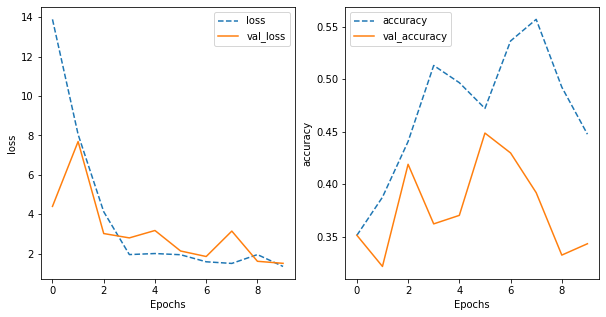

In [ ]:
training_plot(['loss', 'accuracy'], history)

In [ ]:
# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001, # default in Adam constructor
                       l1 = 0,
                       l2 = 0,
                       num_hidden = 128):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/train_set.csv").
      map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/eval_set.csv").
      map(decode_csv)).batch(32) # this doesn't matter

  # NN with one hidden layers
  model = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              tf.keras.layers.Dense(num_hidden,
                                    kernel_regularizer=regularizer, 
                                    activation=tf.keras.activations.relu),
              tf.keras.layers.Dense(len(CLASS_NAMES), 
                                    kernel_regularizer=regularizer,
                                    activation='softmax')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

Epoch 1/10
104/104 [==============================] - 253s 2s/step - loss: 2.1880 - accuracy: 0.3479 - val_loss: 1.4908 - val_accuracy: 0.3730
Epoch 2/10
104/104 [==============================] - 250s 2s/step - loss: 1.4593 - accuracy: 0.4155 - val_loss: 1.3263 - val_accuracy: 0.4054
Epoch 3/10
104/104 [==============================] - 250s 2s/step - loss: 1.3765 - accuracy: 0.4521 - val_loss: 1.2604 - val_accuracy: 0.4676
Epoch 4/10
104/104 [==============================] - 250s 2s/step - loss: 1.3146 - accuracy: 0.4818 - val_loss: 1.3137 - val_accuracy: 0.4595
Epoch 5/10
104/104 [==============================] - 254s 2s/step - loss: 1.2447 - accuracy: 0.5082 - val_loss: 1.3192 - val_accuracy: 0.4595
Epoch 6/10
104/104 [==============================] - 288s 3s/step - loss: 1.1977 - accuracy: 0.5327 - val_loss: 1.3182 - val_accuracy: 0.4703
Epoch 7/10
104/104 [==============================] - 254s 2s/step - loss: 1.1373 - accuracy: 0.5591 - val_loss: 1.2784 - val_accuracy: 0.4811

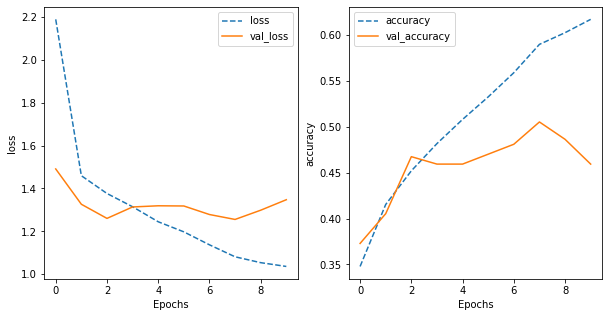

In [ ]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=128)

Epoch 1/10
104/104 [==============================] - 305s 3s/step - loss: 2.5467 - accuracy: 0.3612 - val_loss: 1.5553 - val_accuracy: 0.3784
Epoch 2/10
104/104 [==============================] - 344s 3s/step - loss: 1.4306 - accuracy: 0.4315 - val_loss: 1.5229 - val_accuracy: 0.4324
Epoch 3/10
104/104 [==============================] - 242s 2s/step - loss: 1.3179 - accuracy: 0.4724 - val_loss: 1.3338 - val_accuracy: 0.4568
Epoch 4/10
104/104 [==============================] - 225s 2s/step - loss: 1.2178 - accuracy: 0.5124 - val_loss: 1.3769 - val_accuracy: 0.4622
Epoch 5/10
104/104 [==============================] - 218s 2s/step - loss: 1.2001 - accuracy: 0.5330 - val_loss: 1.3125 - val_accuracy: 0.4622
Epoch 6/10
104/104 [==============================] - 224s 2s/step - loss: 1.1433 - accuracy: 0.5409 - val_loss: 1.2874 - val_accuracy: 0.4757
Epoch 7/10
104/104 [==============================] - 239s 2s/step - loss: 1.0620 - accuracy: 0.5936 - val_loss: 1.3338 - val_accuracy: 0.4784

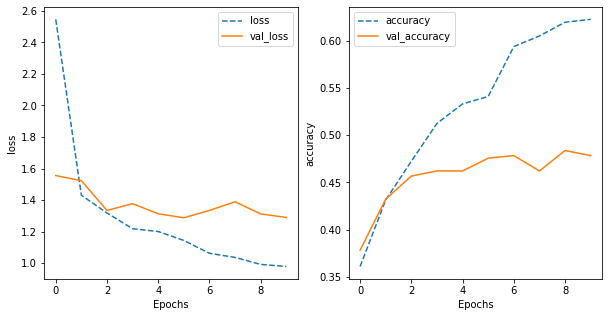

In [ ]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=256)

Epoch 1/10
104/104 [==============================] - 196s 2s/step - loss: 2.9616 - accuracy: 0.3394 - val_loss: 2.3441 - val_accuracy: 0.3757
Epoch 2/10
104/104 [==============================] - 202s 2s/step - loss: 1.8402 - accuracy: 0.4145 - val_loss: 2.3249 - val_accuracy: 0.3946
Epoch 3/10
104/104 [==============================] - 204s 2s/step - loss: 1.6823 - accuracy: 0.4542 - val_loss: 2.5877 - val_accuracy: 0.4297
Epoch 4/10
104/104 [==============================] - 201s 2s/step - loss: 1.6114 - accuracy: 0.4785 - val_loss: 3.0240 - val_accuracy: 0.4297
Epoch 5/10
104/104 [==============================] - 204s 2s/step - loss: 1.7240 - accuracy: 0.4806 - val_loss: 1.8562 - val_accuracy: 0.4405
Epoch 6/10
104/104 [==============================] - 205s 2s/step - loss: 1.4266 - accuracy: 0.5330 - val_loss: 1.6125 - val_accuracy: 0.4703
Epoch 7/10
104/104 [==============================] - 220s 2s/step - loss: 1.3197 - accuracy: 0.5655 - val_loss: 1.4927 - val_accuracy: 0.4892

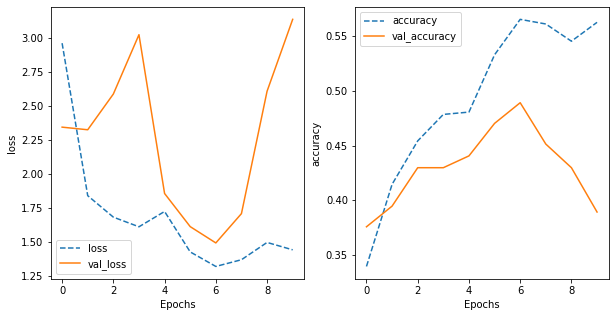

In [ ]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0.001, num_hidden=128)

## Hyperparameter tuning

In [ ]:
!pip install --quiet keras-tuner

In [ ]:
import kerastuner as kt

# parameterize to the values in the previous cell
def build_model(hp):
  lrate = hp.Float('lrate', 1e-4, 1e-1, sampling='log')
  l1 = 0
  l2 = hp.Choice('l2', values=[0.0, 1e-1, 1e-2, 1e-3, 1e-4])
  num_hidden = hp.Int('num_hidden', 32, 256, 32)

  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  # NN with one hidden layers
  model = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              tf.keras.layers.Dense(num_hidden,
                                    kernel_regularizer=regularizer, 
                                    activation=tf.keras.activations.relu),
              tf.keras.layers.Dense(len(CLASS_NAMES), 
                                    kernel_regularizer=regularizer,
                                    activation='softmax')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
  return model

batch_size = 32
train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv)).batch(batch_size)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv)).batch(32) # this doesn't matter

tuner = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective('val_accuracy', 'max'), 
    max_trials=10,
    num_initial_points=2, 
    overwrite=False) # True to start afresh.

tuner.search(
    train_dataset, validation_data=eval_dataset,
    epochs=5,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)]
)

topN = 1
for x in range(topN):
  print(tuner.get_best_hyperparameters(topN)[x].values)
  print(tuner.get_best_models(topN)[x].summary())

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json
Epoch 1/5
104/104 [==============================] - 757s 7s/step - loss: 3864.3066 - accuracy: 0.2085 - val_loss: 4123.6509 - val_accuracy: 0.2351
Epoch 2/5
104/104 [==============================] - 94s 900ms/step - loss: 2201.9370 - accuracy: 0.2188 - val_loss: 3351.5684 - val_accuracy: 0.1892
Epoch 3/5
104/104 [==============================] - 83s 795ms/step - loss: 1329.5459 - accuracy: 0.2112 - val_loss: 531.1631 - val_accuracy: 0.1757
Epoch 4/5
104/104 [==============================] - 83s 799ms/step - loss: 1638.7860 - accuracy: 0.2115 - val_loss: 2245.5068 - val_accuracy: 0.2351


Epoch 1/5
104/104 [==============================] - 83s 801ms/step - loss: 13.1804 - accuracy: 0.3285 - val_loss: 3.0475 - val_accuracy: 0.3757
Epoch 2/5
104/104 [==============================] - 82s 791ms/step - loss: 3.0945 - accuracy: 0.3882 - val_loss: 2.2559 - val_accuracy: 0.4108
Epoch 3/5
104/104 [==============================] - 82s 784ms/step - loss: 2.0945 - accuracy: 0.4612 - val_loss: 4.7337 - val_accuracy: 0.3270


Epoch 1/5
104/104 [==============================] - 82s 792ms/step - loss: 1049.5519 - accuracy: 0.2321 - val_loss: 6.5798 - val_accuracy: 0.2324
Epoch 2/5
104/104 [==============================] - 82s 786ms/step - loss: 1.6024 - accuracy: 0.2421 - val_loss: 6.5702 - val_accuracy: 0.2324
Epoch 3/5
104/104 [==============================] - 82s 788ms/step - loss: 1.6024 - accuracy: 0.2430 - val_loss: 6.5695 - val_accuracy: 0.2324
Epoch 4/5
104/104 [==============================] - 83s 797ms/step - loss: 1.6029 - accuracy: 0.2442 - val_loss: 6.5691 - val_accuracy: 0.2324
Epoch 5/5
104/104 [==============================] - 84s 807ms/step - loss: 1.6032 - accuracy: 0.2442 - val_loss: 6.5688 - val_accuracy: 0.2324


Epoch 1/5
104/104 [==============================] - 85s 815ms/step - loss: 2.8746 - accuracy: 0.3464 - val_loss: 2.0431 - val_accuracy: 0.3676
Epoch 2/5
104/104 [==============================] - 84s 804ms/step - loss: 1.7520 - accuracy: 0.4339 - val_loss: 2.1591 - val_accuracy: 0.3784


Epoch 1/5
104/104 [==============================] - 84s 804ms/step - loss: 8.0946 - accuracy: 0.3464 - val_loss: 2.4991 - val_accuracy: 0.3892
Epoch 2/5
104/104 [==============================] - 84s 812ms/step - loss: 2.6937 - accuracy: 0.4061 - val_loss: 3.1186 - val_accuracy: 0.3405


Epoch 1/5
104/104 [==============================] - 85s 818ms/step - loss: 88.9850 - accuracy: 0.2897 - val_loss: 23.1221 - val_accuracy: 0.2865
Epoch 2/5
104/104 [==============================] - 85s 821ms/step - loss: 18.5632 - accuracy: 0.2039 - val_loss: 11.0950 - val_accuracy: 0.1892
Epoch 3/5
104/104 [==============================] - 84s 812ms/step - loss: 11.6205 - accuracy: 0.2076 - val_loss: 9.5300 - val_accuracy: 0.2162
Epoch 4/5
104/104 [==============================] - 84s 808ms/step - loss: 19.1280 - accuracy: 0.2255 - val_loss: 17.3913 - val_accuracy: 0.2351


Epoch 1/5
104/104 [==============================] - 82s 789ms/step - loss: 4.2190 - accuracy: 0.3218 - val_loss: 2.2792 - val_accuracy: 0.3811
Epoch 2/5
104/104 [==============================] - 80s 765ms/step - loss: 1.7306 - accuracy: 0.4230 - val_loss: 2.3276 - val_accuracy: 0.3946


Epoch 1/5
104/104 [==============================] - 79s 762ms/step - loss: 20.9495 - accuracy: 0.3200 - val_loss: 7.7605 - val_accuracy: 0.2946
Epoch 2/5
104/104 [==============================] - 81s 781ms/step - loss: 7.7160 - accuracy: 0.3570 - val_loss: 11.1996 - val_accuracy: 0.3081


Epoch 1/5
104/104 [==============================] - 79s 758ms/step - loss: 58.2212 - accuracy: 0.3091 - val_loss: 2.5715 - val_accuracy: 0.2162
Epoch 2/5
104/104 [==============================] - 79s 762ms/step - loss: 2.4352 - accuracy: 0.2600 - val_loss: 2.3583 - val_accuracy: 0.2378
Epoch 3/5
104/104 [==============================] - 81s 776ms/step - loss: 2.2629 - accuracy: 0.2473 - val_loss: 2.2025 - val_accuracy: 0.2405
Epoch 4/5
104/104 [==============================] - 80s 768ms/step - loss: 2.1261 - accuracy: 0.2473 - val_loss: 2.0919 - val_accuracy: 0.2378
Epoch 5/5
104/104 [==============================] - 79s 755ms/step - loss: 2.0536 - accuracy: 0.2482 - val_loss: 2.0485 - val_accuracy: 0.2405


Epoch 1/5
104/104 [==============================] - 80s 765ms/step - loss: 40.9416 - accuracy: 0.2658 - val_loss: 16.5827 - val_accuracy: 0.2622
Epoch 2/5
104/104 [==============================] - 79s 761ms/step - loss: 16.8816 - accuracy: 0.3061 - val_loss: 14.7100 - val_accuracy: 0.3081
Epoch 3/5
104/104 [==============================] - 80s 770ms/step - loss: 10.7487 - accuracy: 0.2891 - val_loss: 5.5341 - val_accuracy: 0.3459
Epoch 4/5
104/104 [==============================] - 80s 769ms/step - loss: 4.8290 - accuracy: 0.2452 - val_loss: 6.4887 - val_accuracy: 0.2351


INFO:tensorflow:Oracle triggered exit
{'lrate': 0.00017013245197465996, 'l2': 0.0, 'num_hidden': 64}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                9633856   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 9,634,181
Trainable params: 9,634,181
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
topN = 1
for x in range(topN):
  print(tuner.get_best_hyperparameters(topN)[x].values)
  print(tuner.get_best_models(topN)[x].summary())
  

{'lrate': 0.00017013245197465996, 'l2': 0.0, 'num_hidden': 64}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                9633856   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 9,634,181
Trainable params: 9,634,181
Non-trainable params: 0
_________________________________________________________________
None


The best set of hyperparameters: 
* l2=0, lrate=0.00017, num_hidden=64 score=0.4595

## Deep Neural Network

Let's train a DNN.
We will parameterize the number of layers, and the
number of nodes in each layer

In [ ]:
# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.0001,
                       l1 = 0,
                       l2 = 0.001,
                       num_hidden = [64, 16]):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/train_set.csv").
      map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/eval_set.csv").
      map(decode_csv)).batch(32) # this doesn't matter

  # NN with multiple hidden layers
  layers = [tf.keras.layers.Flatten(
      input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
      name='input_pixels')]
  layers = layers + [
      tf.keras.layers.Dense(nodes,
                            kernel_regularizer=regularizer, 
                            activation=tf.keras.activations.relu,
                            name='hidden_dense_{}'.format(hno))
          for hno, nodes in enumerate(num_hidden)
  ]
  layers = layers + [
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
  ]

  model = tf.keras.Sequential(layers, name='flower_classification')
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_pixels (Flatten)       (None, 150528)            0         
_________________________________________________________________
hidden_dense_0 (Dense)       (None, 64)                9633856   
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 16)                1040      
_________________________________________________________________
flower_prob (Dense)          (None, 5)                 85        
Total params: 9,634,981
Trainable params: 9,634,981
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
104/104 [==============================] - 1298s 12s/step - loss: 1.8584 - accuracy: 0.3142 - val_loss: 1.6154 - val_accuracy: 0.3703
Epoch 2/10
104/104 [==============================] - 394s 4s/step - loss: 1.6173 - accuracy

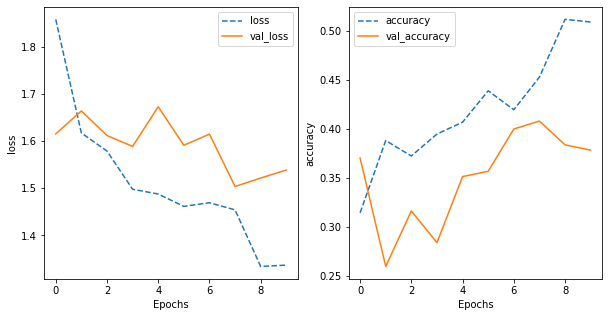

In [ ]:
model = train_and_evaluate(lrate=0.0001, l2=0.001, num_hidden = [64, 16])

### Dropout and batchnorm
Add a dropout and batchnorm layer after each of the hidden layers.


In [ ]:
def train_and_evaluate(batch_size = 32,
                       lrate = 0.0001,
                       l1 = 0,
                       l2 = 0.001,
                       dropout_prob = 0.4,
                       num_hidden = [64, 16]):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/train_set.csv").
      map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/eval_set.csv").
      map(decode_csv)).batch(32) # this doesn't matter

  # NN with multiple hidden layers
  layers = [tf.keras.layers.Flatten(
      input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
      name='input_pixels')]
  for hno, nodes in enumerate(num_hidden):
    layers.extend([
      tf.keras.layers.Dense(nodes,
                            kernel_regularizer=regularizer, 
                            name='hidden_dense_{}'.format(hno)),
      tf.keras.layers.BatchNormalization(scale=False, # ReLU
                                         center=False, # have bias in Dense
                                         name='batchnorm_dense_{}'.format(hno)),
      #move activation to come after batchnorm
      tf.keras.layers.Activation('relu', name='relu_dense_{}'.format(hno)),
      tf.keras.layers.Dropout(rate=dropout_prob,
                             name='dropout_dense_{}'.format(hno)),                         
    ])

  layers.append(
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
  )

  model = tf.keras.Sequential(layers, name='flower_classification')
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

Model: "flower_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_pixels (Flatten)       (None, 150528)            0         
_________________________________________________________________
hidden_dense_0 (Dense)       (None, 64)                9633856   
_________________________________________________________________
batchnorm_dense_0 (BatchNorm (None, 64)                128       
_________________________________________________________________
relu_dense_0 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_dense_0 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 16)                1040      
_________________________________________________________________
batchnorm_dense_1 (BatchNorm (None, 16)      

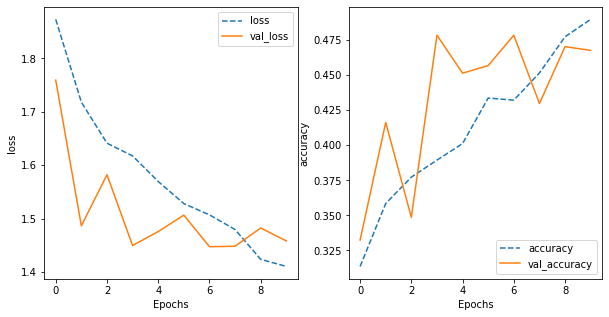

In [ ]:
model = train_and_evaluate(dropout_prob=0.4)

## Diagrams

These plot the diagrams in the book.

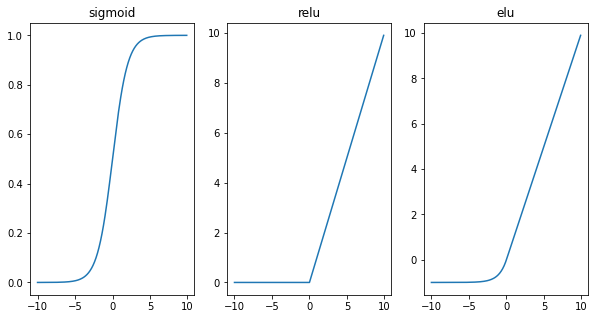

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt

fig, ax = plt.subplots(1, 3, figsize=(10,5))
x = np.arange(-10.0, 10.0, 0.1)
y = tf.keras.activations.sigmoid(x)
ax[0].plot(x, y);
ax[0].set_title("sigmoid")
y = tf.keras.activations.relu(x)
ax[1].plot(x, y);
ax[1].set_title("relu")
y = tf.keras.activations.elu(x)
ax[2].plot(x, y);
ax[2].set_title("elu");

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               19267712  
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 19,268,357
Trainable params: 19,268,357
Non-trainable params: 0
_________________________________________________________________


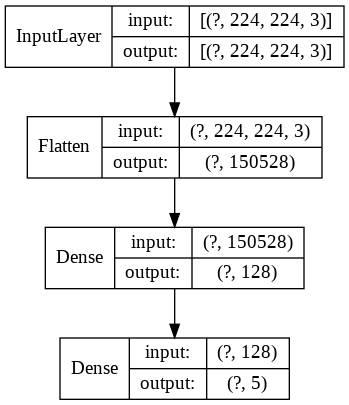

In [ ]:
model = tf.keras.Sequential([
   tf.keras.layers.Flatten(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
   tf.keras.layers.Dense(128, activation='relu'),
   tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
model = tf.keras.Sequential([
   tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
   tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 752645    
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
_________________________________________________________________


Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.